## TL;DR

Scatter shows some grouping of samples under One-vs-All scenario (e.g. worm vs other, etc)

In [31]:
import matplotlib

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from pandas.plotting import parallel_coordinates

data_folder = '../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

df = pd.read_csv(build_path('malwr_behav_categories')).set_index('link')
file_info = pd.read_csv(build_path('malwr_file_info'), dtype=str).set_index('link')[['md5']]
file_info.drop_duplicates(keep='last', inplace=True)
df = df[df.index.isin(file_info.index)]
goodware = pd.read_csv(build_path('goodware_real'), dtype=str).link
malware_labeled = pd.read_csv(build_path('malware_labeled'), dtype=str).set_index('link')

goodware = goodware[~goodware.isin(malware_labeled.index)]
malware_labeled = malware_labeled[~malware_labeled.isin(goodware)]

# malware_detailed = file_info.join(malware_labeled, on='md5', how='inner').drop('md5', axis=1)
malware_detailed = malware_labeled

malwr_vendors_filtered = pd.read_csv(build_path('malwr_vendors_filtered'), dtype=str).set_index('link')
score = malwr_vendors_filtered.replace('Clean', np.nan).count(axis=1)
ambiguous_score = score[(score < 5) & (score > 0)].index
malware_detailed = malware_detailed[~malware_detailed.index.isin(ambiguous_score)]

df = df[(df.index.isin(goodware)) | (df.index.isin(malware_detailed.index))]

df_stats = df.describe()

In [20]:
display(df_stats)

anomaly         device    filesystem       hooking           misc  \
count  9790.000000   85572.000000  1.271170e+05  34286.000000  102197.000000   
mean    146.758223     190.428353  3.806895e+03     12.739077     230.521806   
std     138.415130    4080.698758  1.908878e+04    122.488959    3274.759592   
min       1.000000       1.000000  1.000000e+00      1.000000       1.000000   
25%      18.000000       7.000000  1.400000e+01      2.000000       4.000000   
50%     152.000000      21.000000  1.480000e+02      3.000000      19.000000   
75%     166.000000      35.000000  1.025000e+03      6.000000     113.000000   
max    1837.000000  456906.000000  1.080794e+06  10678.000000  691595.000000   

             network        process       registry      services  \
count   33695.000000  129947.000000  125380.000000  44901.000000   
mean      360.047010    2675.890055    2481.987614     35.620075   
std      6218.569198   22173.248917   11229.999366    586.905722   
min         1.000000       1.000000       1.000000      1.000000   
25%         2.000000      14.000000      31.000000      3.000000   
50%         8.000000      52.000000     260.000000      6.000000   
75%        39.000000     337.000000    1509.000000     11.000000   
max    719692.000000  854473.000000  866286.000000  58141.000000   

             socket  synchronization         system      threading  \
count  5.956900e+04    112904.000000  131649.000000   77569.000000   
mean   1.512059e+03       171.565693    1924.861662     122.240728   
std    2.049735e+04      4943.432685    9794.108832    2505.225260   
min    1.000000e+00         1.000000       1.000000       1.000000   
25%    5.000000e+00         2.000000      80.000000       4.000000   
50%    2.200000e+01         5.000000     307.000000       9.000000   
75%    1.380000e+02        13.000000     926.000000      24.000000   
max    1.401256e+06    465877.000000  805513.000000  542599.000000   

             windows  
count   68514.000000  
mean      331.479625  
std      4354.374843  
min         1.000000  
25%         1.000000  
50%         1.000000  
75%         5.000000  
max    432640.000000

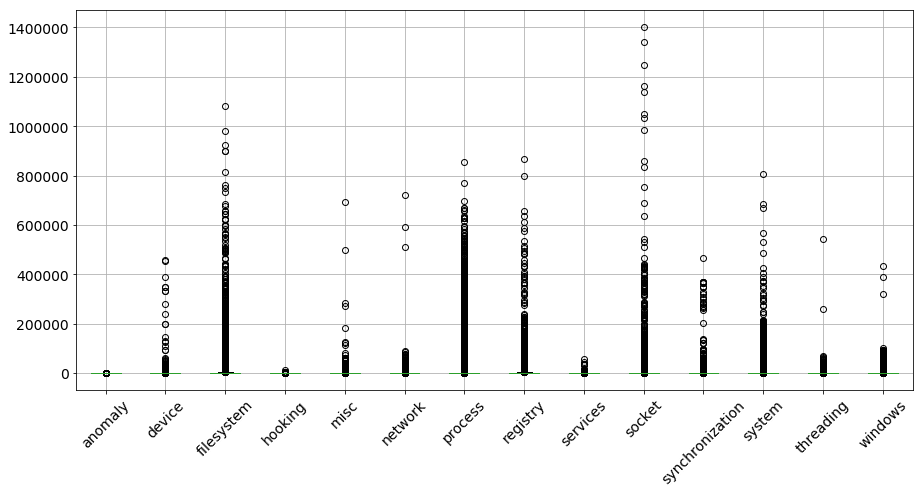

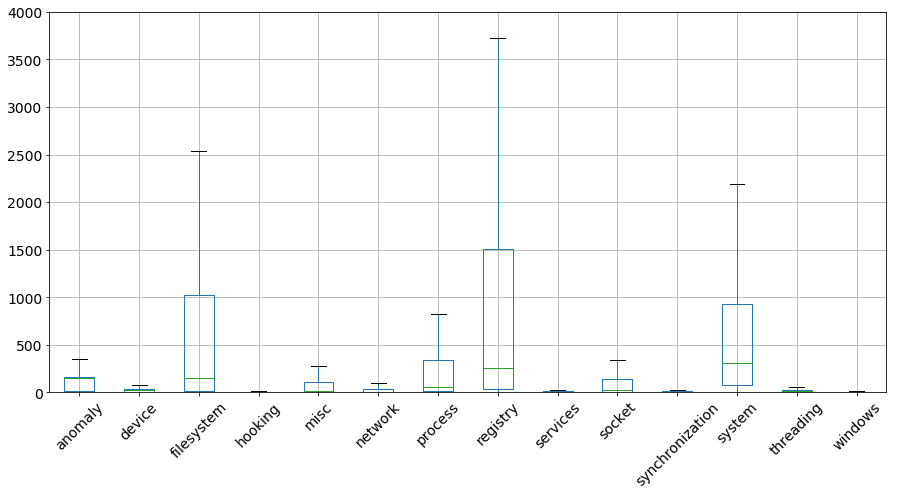

In [32]:
matplotlib.rcParams.update({'font.size': 14})
df.boxplot(figsize=(15,7), rot=45)
plt.show()
df.boxplot(figsize=(15,7), rot=45, showfliers=False)
plt.ylim(-1, 4000)
plt.show()

In [29]:
rescaledX = QuantileTransformer(output_distribution='normal').fit_transform(df.fillna(0))
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(rescaledX)

In [30]:
learn_ready = pd.DataFrame(rescaledX, index=df.index, columns=df.columns)
learn_ready.loc[learn_ready.index.isin(goodware), 'malware'] = 0
learn_ready.loc[learn_ready.index.isin(malware_detailed.index), 'malware'] = 1
learn_ready.malware = learn_ready.malware.astype(bool)
learn_ready.to_csv(build_path('learn_behav_categories2'), compression='gzip')

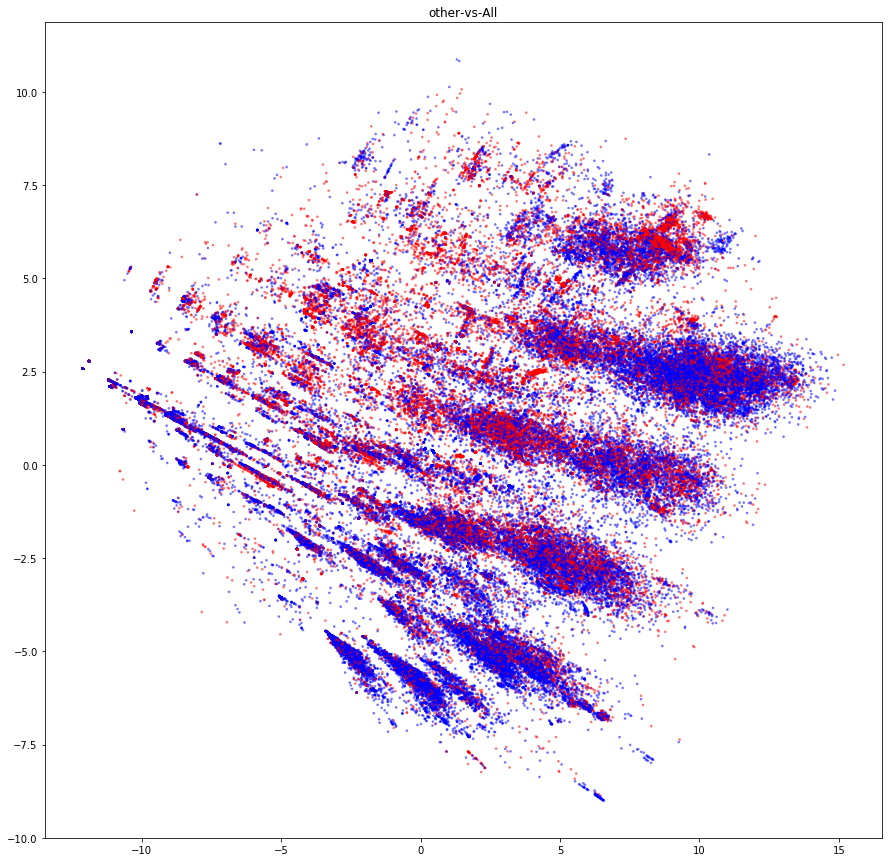

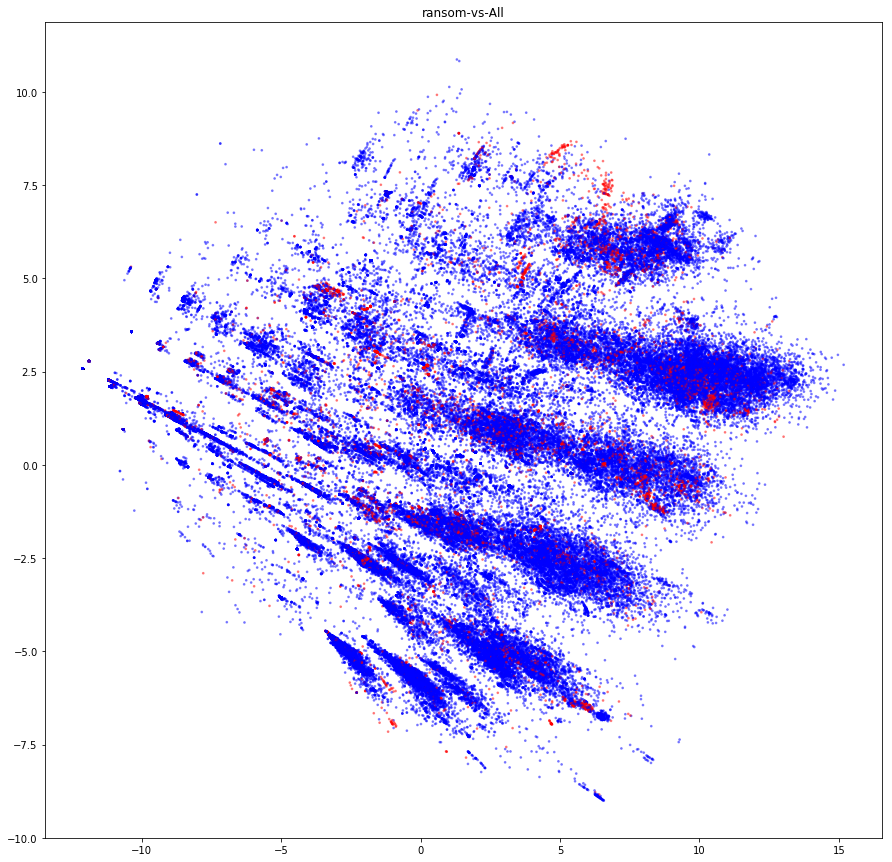

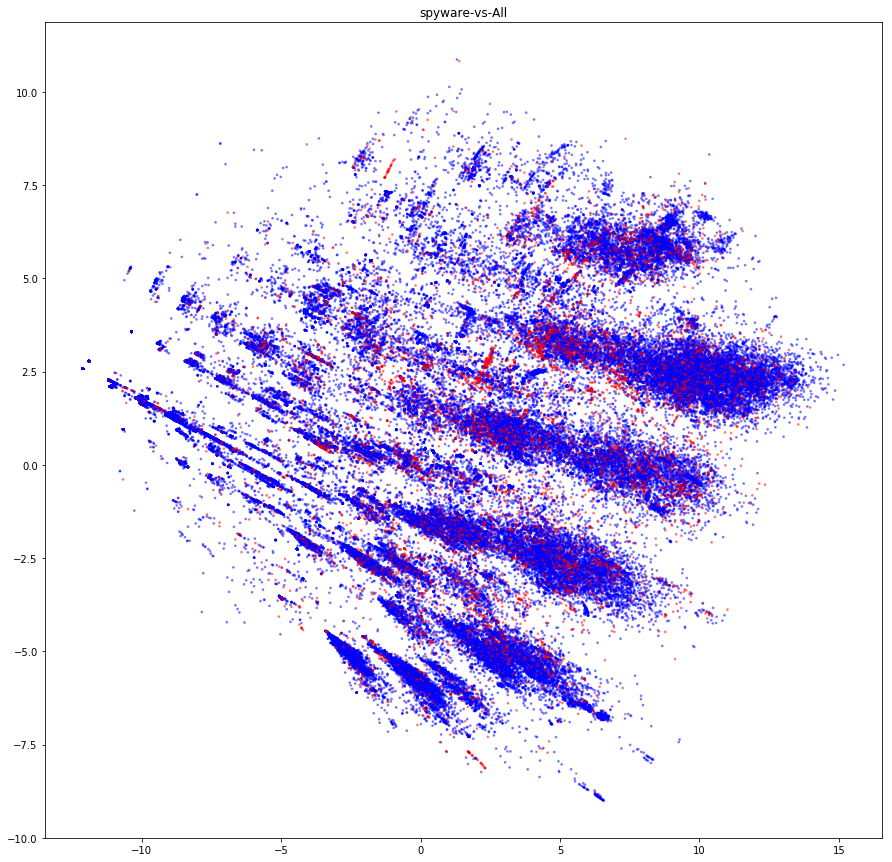

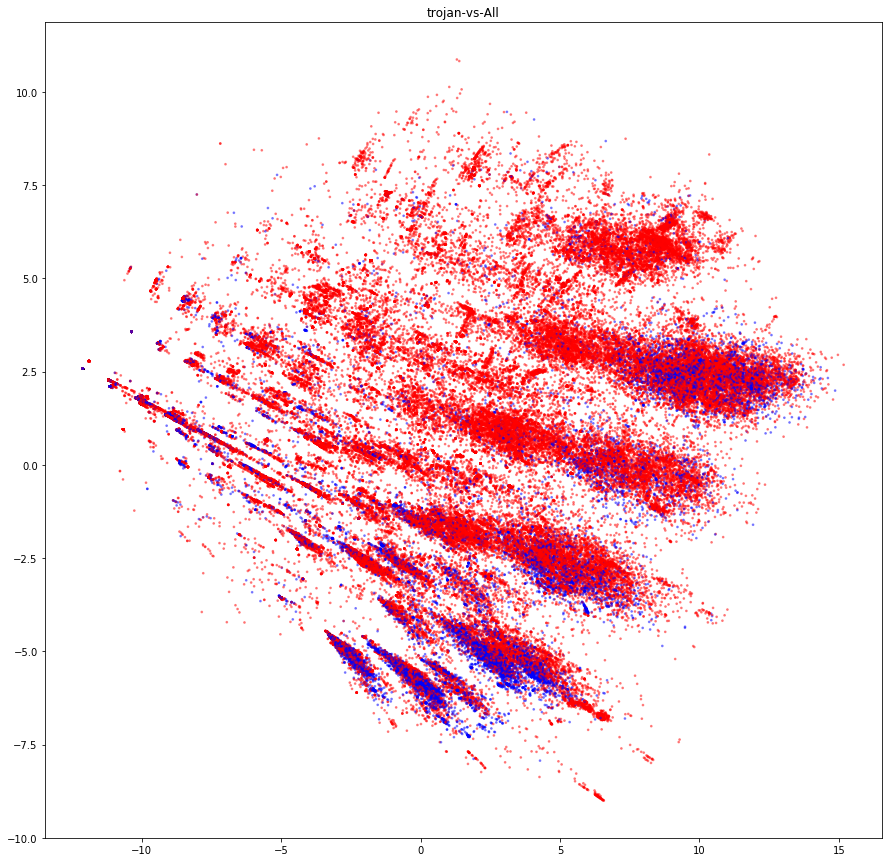

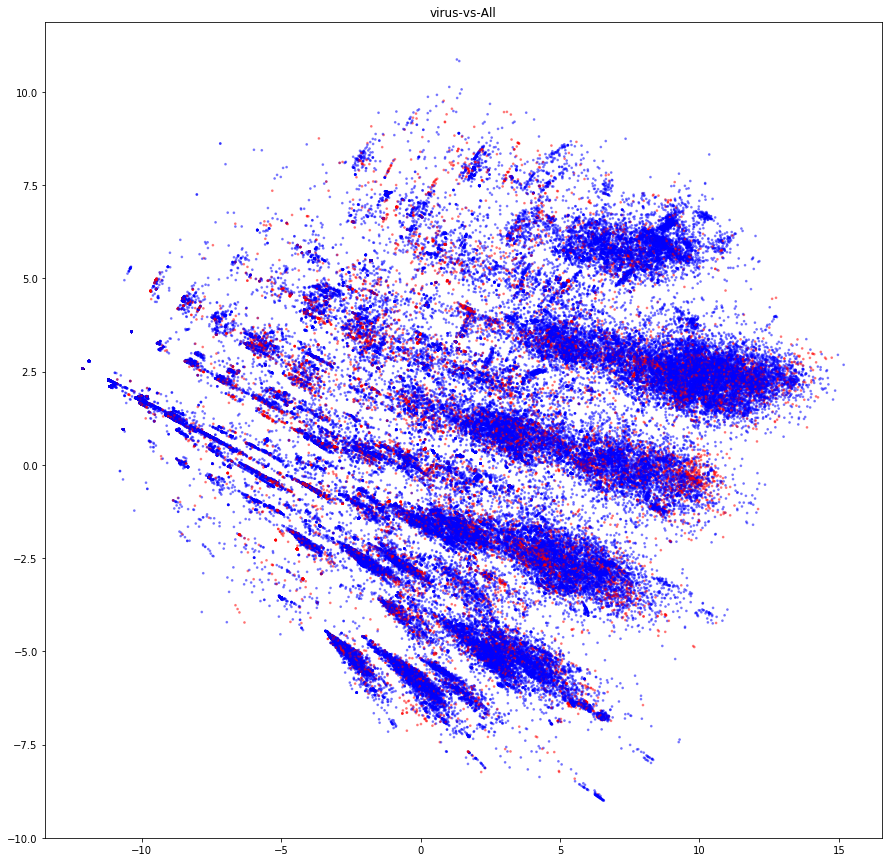

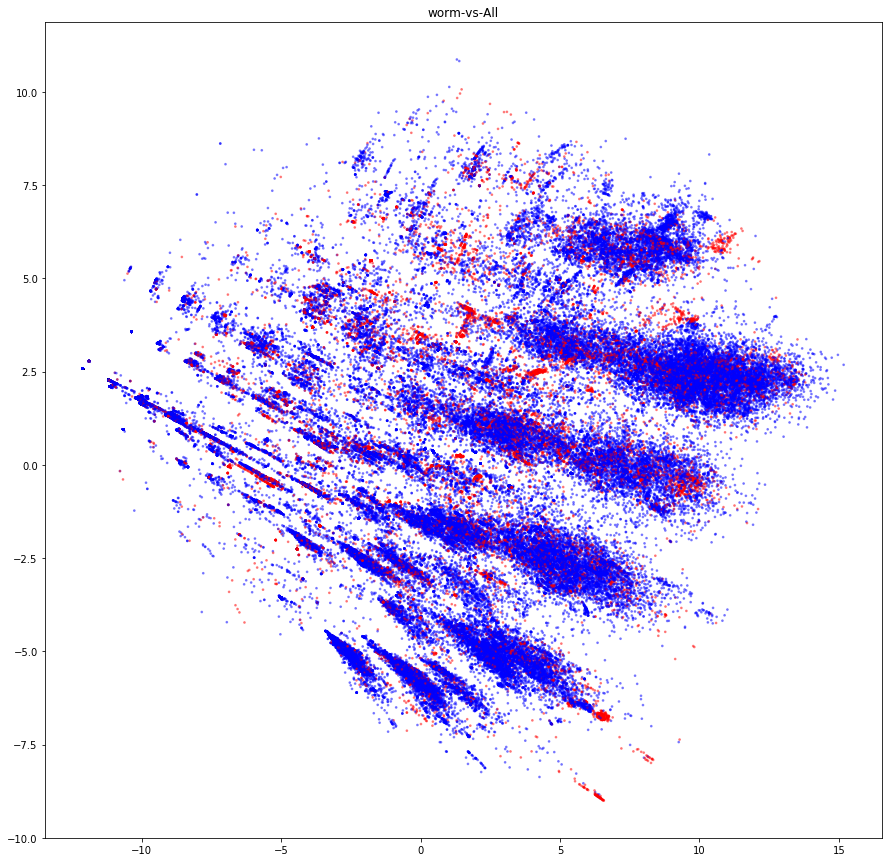

In [5]:
temp = pd.DataFrame(df.index).set_index('link')
for mal_type in malware_detailed.columns:
    malware = malware_detailed[mal_type].dropna()
    temp.loc[:, 'malware'] = 0
    temp.loc[temp.index.isin(malware.index), 'malware'] = 1
    
    plt.figure(figsize=(15, 15))
    plt.scatter(reduced_data[:,0], reduced_data[:,1], c=temp.malware, cmap='bwr', s=3, alpha=0.4)
    plt.title('{}-vs-All'.format(mal_type))
    plt.show()

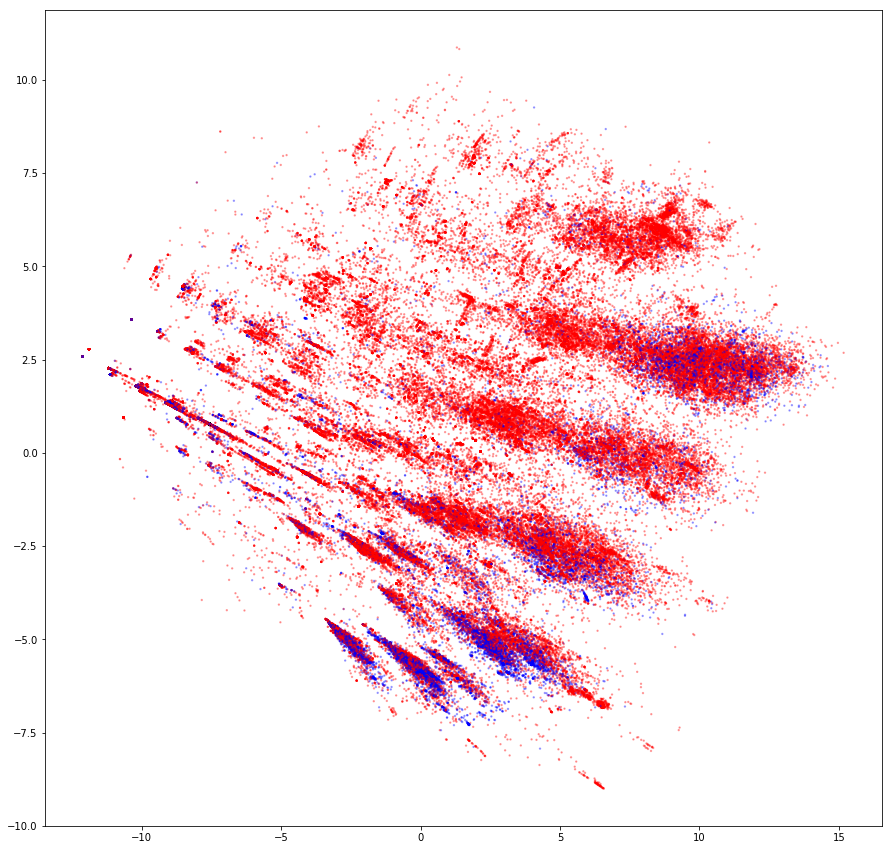

In [6]:
temp = pd.DataFrame(df.index).set_index('link')
temp.loc[:, 'malware'] = 1
temp.loc[temp.index.isin(goodware)] = 0
plt.figure(figsize=(15, 15))
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=temp.malware, cmap='bwr', s=2, alpha=0.3)
plt.show()